**Train End-to-End Functional Model**

Tn this we solve the problem:-
* In kaggle data contain the "face" data we have to predict the age and gender wrt to face


In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

100% 330M/331M [00:20<00:00, 15.3MB/s]
100% 331M/331M [00:20<00:00, 16.8MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [4]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [5]:
# give the path
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
# in the data label ---> it contain the age and gender information in the label, so we can pull out the info from the label of the image and put into the tabel

age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))   # start label 0 indexing is age
  gender.append(int(file.split('_')[1]))  # after age it contain the gender detail
  img_path.append(file)

In [7]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [8]:
df.head(5)

,age,gender,img
0,50,0,50_0_3_20170117144239634.jpg.chip.jpg
1,74,0,74_0_0_20170111222222432.jpg.chip.jpg
2,21,1,21_1_0_20170116215450607.jpg.chip.jpg
3,26,1,26_1_1_20170116153812488.jpg.chip.jpg
4,26,0,26_0_0_20170113135336472.jpg.chip.jpg


In [9]:
# 1st it give and in gender 0/1 and detail

len(age)

23708

In [10]:
df.shape

(23708, 3)

In [11]:
# now divide the data into train and test cases
# 0-20000 -- train 
# 20000 > test

train_df = df.sample(frac=1, random_state = 0).iloc[:20000]
test_df = df.sample(frac = 1, random_state = 0).iloc[20000:]


In [12]:
train_df.shape

(20000, 3)

In [13]:
test_df.shape

(3708, 3)

In [14]:
# now data is less so we can apply the "Data Agumentation"

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip =True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# generator

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender'],  # in this we contain the 2 o/p col.
                                                    target_size = (200,200),
                                                    class_mode='multi_output')  # so output -- multi output
                                                   

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 directory = folder_path,
                                                 x_col = 'img',
                                                 y_col = ['age','gender'],
                                                 target_size = (200,200),
                                                 class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [16]:
# Transfer Learning ---> vgg16 and resnet50

In [17]:
# vgg16
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [18]:
vggnet = VGG16(include_top = False, input_shape = (200,200,3))      # as input

# include_top --> we require only "Convolution base"

58889256/58889256 [==============================] - 4s 0us/step


In [19]:
vggnet.trainable = False

output = vggnet.layers[-1].output   # last layer ko uda ker output me put ker reha hu 

flatten = Flatten()(output)     # flatten data and connect to the last layer [output]

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation = 'relu')(flatten)

dense3 = Dense(512,activation = 'relu')(dense1)
dense4 = Dense(512,activation = 'relu')(dense2)

output1 = Dense(1,activation = 'linear',name = 'age')(dense3)  # in this we can provide the name of the output layer "age"
output2 = Dense(1,activation = 'sigmoid', name = 'gender')(dense4)

In [20]:
model = Model(inputs= vggnet.input,outputs = [output1,output2])

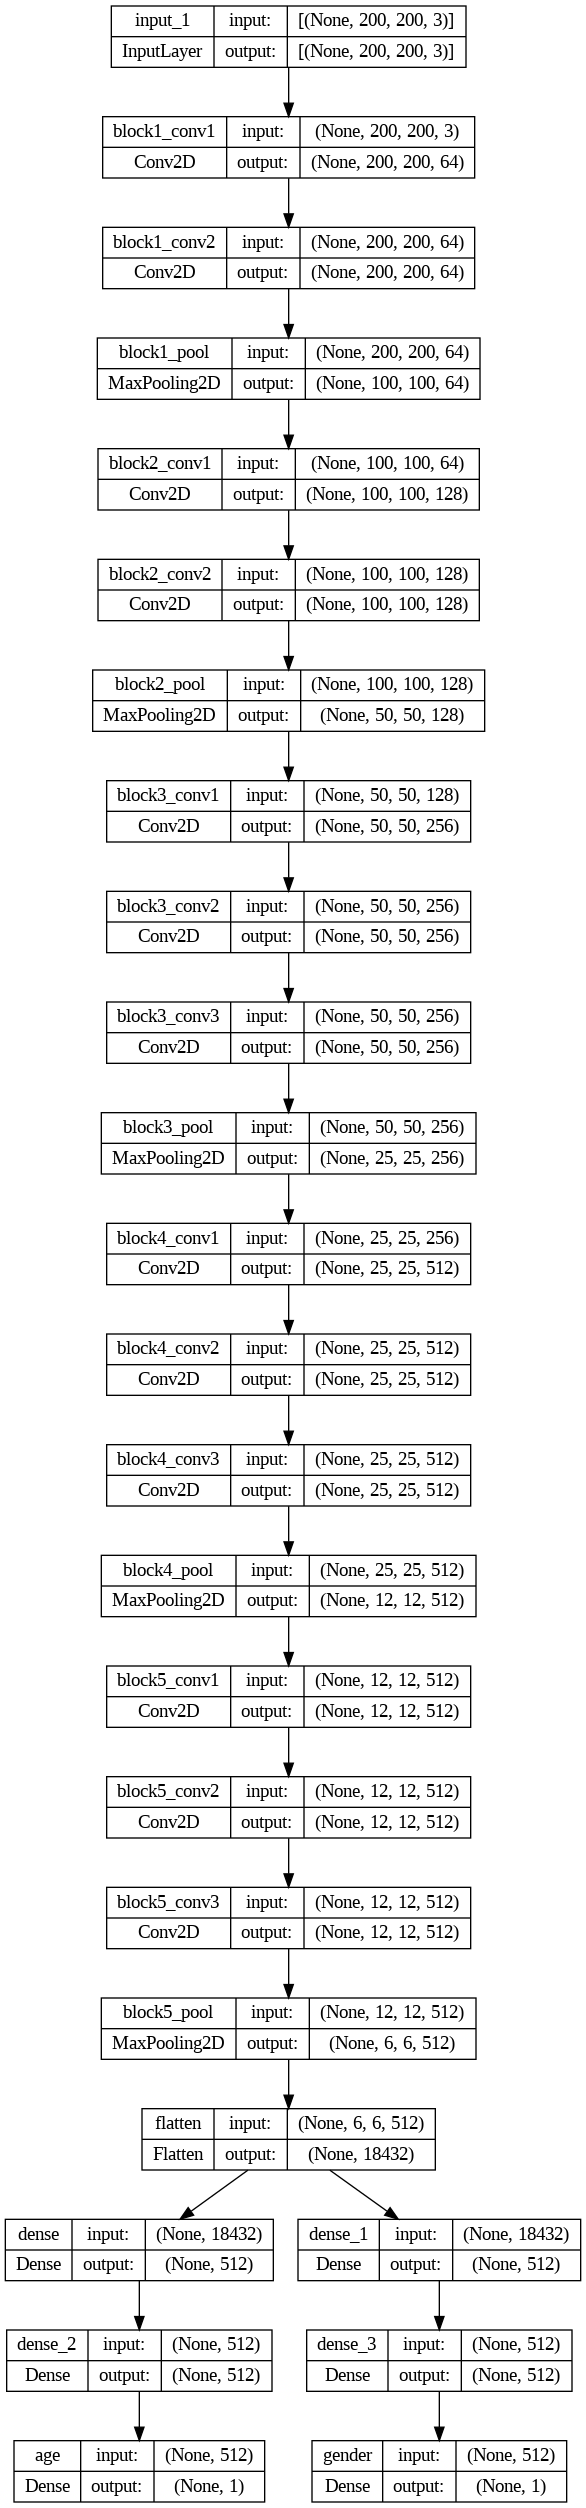

In [21]:
from keras.utils import plot_model
plot_model(model,show_shapes =True)

In [23]:
model.compile(optimizer = 'adam', loss = {'age':'mae','gender':'binary_crossentropy'},metrics = {'age':'mae','gender':'accuracy'}, loss_weights={'age':1,'gender':99})

In [24]:
model.fit(train_generator, batch_size = 32, epochs = 10, validation_data = test_generator)

Epoch 1/10
625/625 [==============================] - 245s 369ms/step - loss: 63.3359 - age_loss: 10.9649 - gender_loss: 0.5290 - age_mae: 10.9649 - gender_accuracy: 0.7481 - val_loss: 45.2050 - val_age_loss: 9.0792 - val_gender_loss: 0.3649 - val_age_mae: 9.0792 - val_gender_accuracy: 0.8436
Epoch 2/10
625/625 [==============================] - 225s 360ms/step - loss: 53.9089 - age_loss: 9.3167 - gender_loss: 0.4504 - age_mae: 9.3167 - gender_accuracy: 0.7851 - val_loss: 43.6676 - val_age_loss: 10.0168 - val_gender_loss: 0.3399 - val_age_mae: 10.0168 - val_gender_accuracy: 0.8509
Epoch 3/10
625/625 [==============================] - 227s 362ms/step - loss: 51.6205 - age_loss: 9.1030 - gender_loss: 0.4295 - age_mae: 9.1030 - gender_accuracy: 0.7965 - val_loss: 41.6621 - val_age_loss: 8.3548 - val_gender_loss: 0.3364 - val_age_mae: 8.3548 - val_gender_accuracy: 0.8576
Epoch 4/10
625/625 [==============================] - 230s 368ms/step - loss: 49.4607 - age_loss: 8.7430 - gender_loss: 